In [46]:
!pip3 install pandas --upgrade
!pip3 install numpy --upgrade

In [47]:
!pip install wordcloud

In [48]:
import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as plx
from math import sqrt
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
import boto3
import sagemaker
import sagemaker.amazon.common as smac # sagemaker common libary
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import CSVSerializer
import os
import io

### 1. Exploring the data (EDA)

In [49]:
car_df = pd.read_csv('datasets/used_car_price.csv')

In [50]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 428 entries, 0 to 427
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Make         428 non-null    object 
 1   Model        428 non-null    object 
 2   Type         428 non-null    object 
 3   Origin       428 non-null    object 
 4   DriveTrain   428 non-null    object 
 5   MSRP         428 non-null    int64  
 6   EngineSize   428 non-null    float64
 7   Cylinders    428 non-null    int64  
 8   Horsepower   428 non-null    int64  
 9   MPG_City     428 non-null    int64  
 10  MPG_Highway  428 non-null    int64  
 11  Weight       428 non-null    int64  
 12  Wheelbase    428 non-null    int64  
 13  Length       428 non-null    int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 46.9+ KB


In [51]:
# Other way to check if any missing values are present in the dataframe
car_df.isnull().sum()

Make           0
Model          0
Type           0
Origin         0
DriveTrain     0
MSRP           0
EngineSize     0
Cylinders      0
Horsepower     0
MPG_City       0
MPG_Highway    0
Weight         0
Wheelbase      0
Length         0
dtype: int64

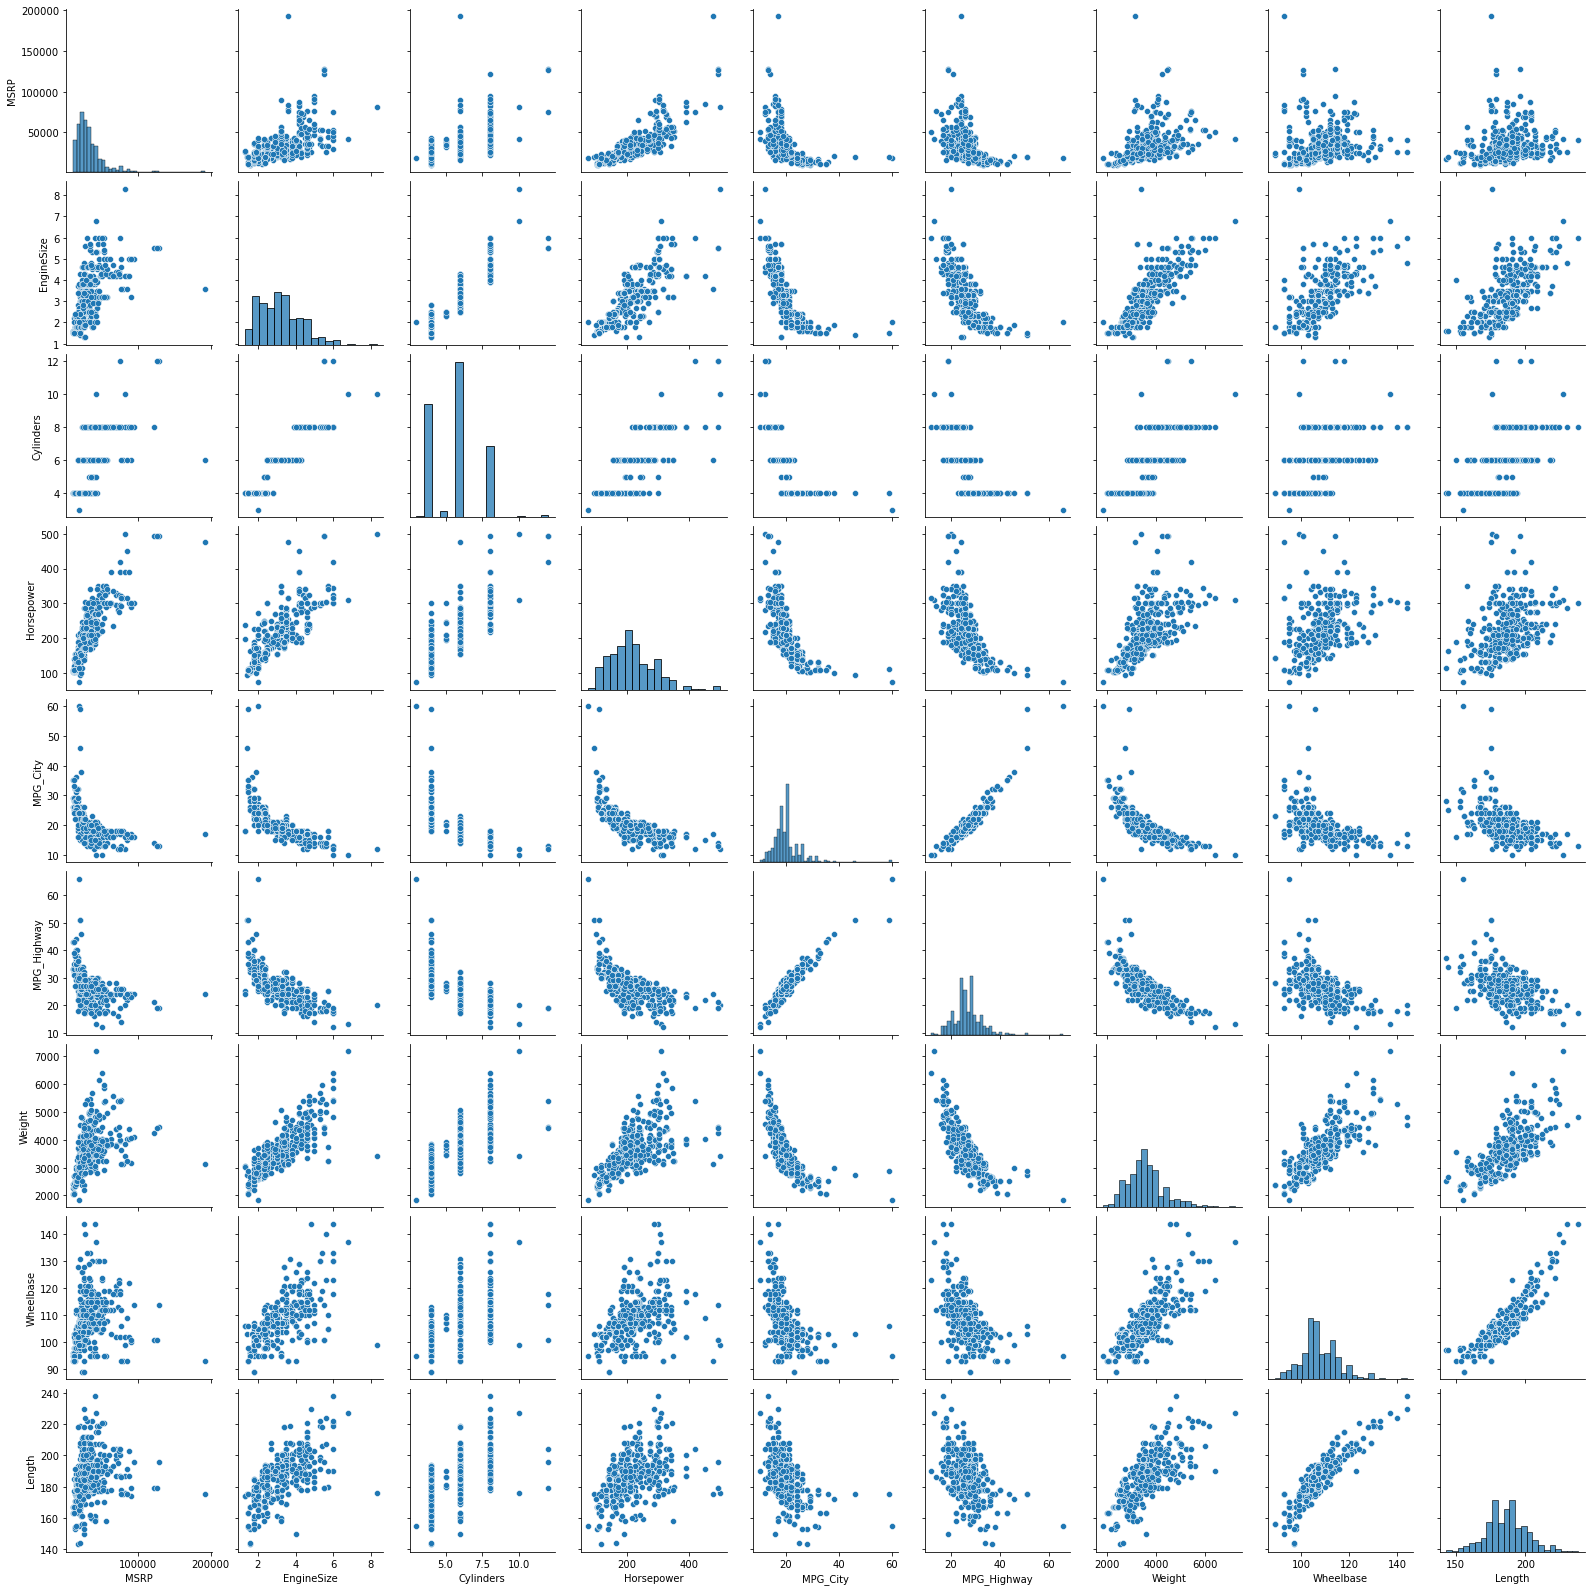

In [52]:
sns.pairplot(car_df) 

<AxesSubplot:xlabel='DriveTrain', ylabel='count'>

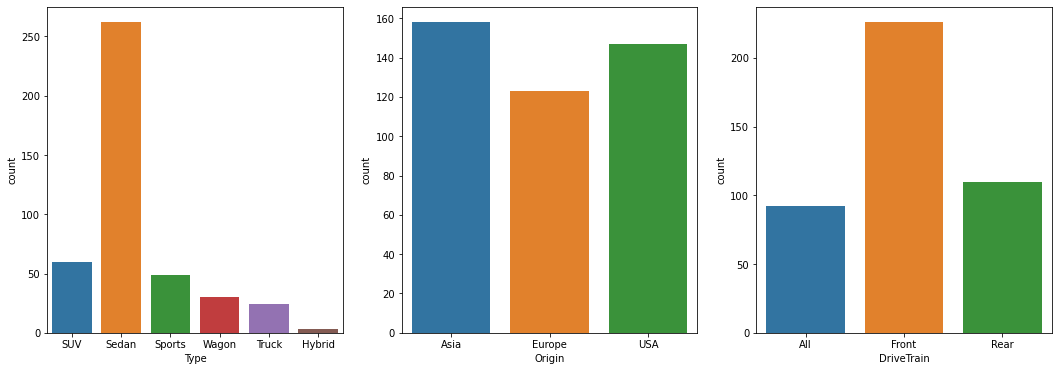

In [53]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
sns.countplot(x = car_df['Type'], ax=ax1)
sns.countplot(x = car_df['Origin'], ax=ax2)
sns.countplot(x = car_df['DriveTrain'], ax=ax3)

In [54]:
stopwords = set(STOPWORDS)

In [55]:
wc = WordCloud(background_color = "black", max_words = 2000, max_font_size = 100, random_state = 3, 
              stopwords = stopwords, contour_width = 3).generate(str(car_df.Model.values))  

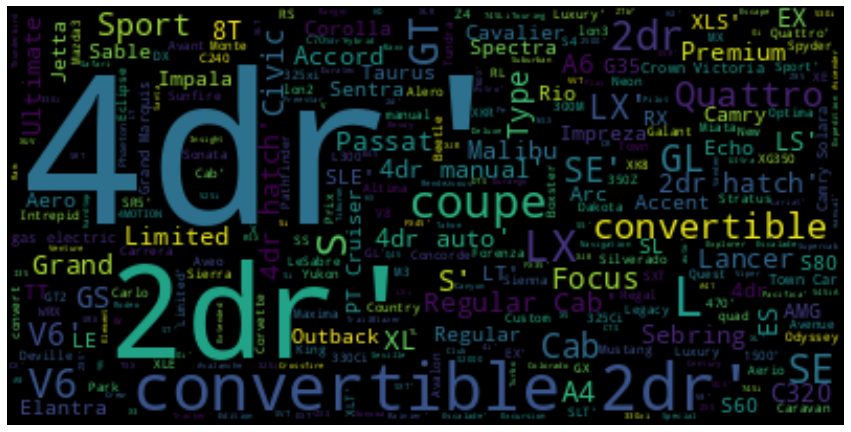

In [56]:
fig = plt.figure(figsize = (15, 15))
plt.imshow(wc, interpolation = "bilinear")
plt.axis("off")
plt.show()

In [57]:
car_df.corr()

,MSRP,EngineSize,Cylinders,Horsepower,MPG_City,MPG_Highway,Weight,Wheelbase,Length
MSRP,1.000000,0.571753,0.649308,0.826945,-0.475020,-0.439622,0.448426,0.152000,0.172037
EngineSize,0.571753,1.000000,0.908186,0.787435,-0.709471,-0.717302,0.807867,0.636517,0.637448
Cylinders,0.649308,0.908186,1.000000,0.807523,-0.679872,-0.671488,0.742849,0.546337,0.549785
Horsepower,0.826945,0.787435,0.807523,1.000000,-0.676699,-0.647195,0.630796,0.387398,0.381554
MPG_City,-0.475020,-0.709471,-0.679872,-0.676699,1.000000,0.941021,-0.737966,-0.507284,-0.501526
MPG_Highway,-0.439622,-0.717302,-0.671488,-0.647195,0.941021,1.000000,-0.790989,-0.524661,-0.466092
Weight,0.448426,0.807867,0.742849,0.630796,-0.737966,-0.790989,1.000000,0.760703,0.690021
Wheelbase,0.152000,0.636517,0.546337,0.387398,-0.507284,-0.524661,0.760703,1.000000,0.889195
Length,0.172037,0.637448,0.549785,0.381554,-0.501526,-0.466092,0.690021,0.889195,1.000000


<AxesSubplot:>

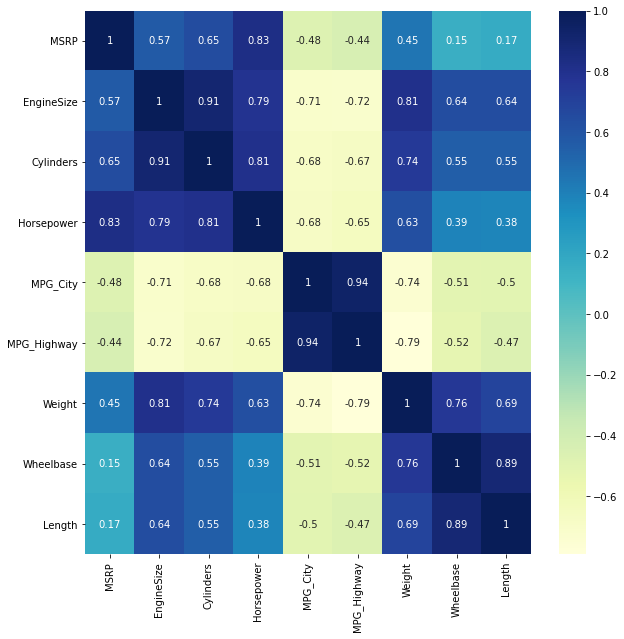

In [58]:
fig = plt.figure(figsize = (10, 10))
sns.heatmap(car_df.corr(), cmap='YlGnBu', annot=True)

### 2. Preparing data

In [59]:
# One-Hot Encoding for "Make", "Model", "Type", "Origin", and "DriveTrain"
car_df = pd.get_dummies(car_df, columns=["Make", "Model", "Type", "Origin", "DriveTrain"])
car_df.head()

,MSRP,EngineSize,Cylinders,Horsepower,MPG_City,MPG_Highway,Weight,Wheelbase,Length,Make_Acura,...,Type_Sedan,Type_Sports,Type_Truck,Type_Wagon,Origin_Asia,Origin_Europe,Origin_USA,DriveTrain_All,DriveTrain_Front,DriveTrain_Rear
0,36945,3.5,6,265,17,23,4451,106,189,1,...,0,0,0,0,1,0,0,1,0,0
1,23820,2.0,4,200,24,31,2778,101,172,1,...,1,0,0,0,1,0,0,0,1,0
2,26990,2.4,4,200,22,29,3230,105,183,1,...,1,0,0,0,1,0,0,0,1,0
3,33195,3.2,6,270,20,28,3575,108,186,1,...,1,0,0,0,1,0,0,0,1,0
4,43755,3.5,6,225,18,24,3880,115,197,1,...,1,0,0,0,1,0,0,0,1,0


In [60]:
# Feeding input features to X and output to y
x = car_df.drop("MSRP", axis = 1)
y = car_df["MSRP"]

In [61]:
x = np.array(x).astype('float32')
y = np.array(y).astype('float32')

In [62]:
x[0:10]

array([[  3.5,   6. , 265. , ...,   1. ,   0. ,   0. ],
       [  2. ,   4. , 200. , ...,   0. ,   1. ,   0. ],
       [  2.4,   4. , 200. , ...,   0. ,   1. ,   0. ],
       ...,
       [  1.8,   4. , 170. , ...,   0. ,   1. ,   0. ],
       [  1.8,   4. , 170. , ...,   0. ,   1. ,   0. ],
       [  3. ,   6. , 220. , ...,   0. ,   1. ,   0. ]], dtype=float32)

In [63]:
y[0:10]

array([36945., 23820., 26990., 33195., 43755., 46100., 89765., 25940.,
       35940., 31840.], dtype=float32)

In [64]:
x_train, x_test, y_train, y_test= train_test_split(x, y, test_size = 0.25)

In [65]:
print('x_train {0}, y_train {1}, x_test {2}, y_test{3}'.format(x_train.shape, y_train.shape, x_test.shape, y_test.shape))

x_train (321, 483), y_train (321,), x_test (107, 483), y_test(107,)


In [66]:
x_train

array([[  4.2,   8. , 450. , ...,   0. ,   1. ,   0. ],
       [  3.5,   6. , 265. , ...,   1. ,   0. ,   0. ],
       [  1.7,   4. , 115. , ...,   0. ,   1. ,   0. ],
       ...,
       [  3. ,   6. , 215. , ...,   0. ,   0. ,   1. ],
       [  2.7,   6. , 170. , ...,   0. ,   1. ,   0. ],
       [  1.4,   4. ,  93. , ...,   0. ,   1. ,   0. ]], dtype=float32)

### 3. SageMaker configuration

In [67]:
sagemaker_session = sagemaker.Session()
bucket = 'varsmetagen-dev-static' # bucket need to be created beforehand
prefix = 'teste/tania/linear_learner_multiple_regression' # prefix is the subfolder within the bucket.
role = sagemaker.get_execution_role()
print(role)

arn:aws:iam::078345292105:role/service-role/AmazonSageMaker-ExecutionRole-20220519T180533


### 4. Converts the train data to recordIO and uploads to S3

In [68]:
# Code below converts the data in numpy array format to RecordIO format
# This is one of the formats accepted by Sagemaker Linear Learner 
# the code below will create an in-memory byte array 
# When you write to in-memory byte arrays, it increments 1 every time you write to it
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, x_train, y_train.reshape(-1,))
buf.seek(0) 

0

In [69]:
# Code to upload RecordIO data to S3 to be accessed later for training
key = 'linear-train-data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning:

Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/



uploaded training data location: s3://varsmetagen-dev-static/teste/tania/linear_learner_multiple_regression/train/linear-train-data


### 5. Converts the test data to recordIO and uploads to S3

In [70]:
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, x_test, y_test.reshape(-1,))
buf.seek(0) 

0

In [71]:
# Code to upload RecordIO data to S3 to be accessed later for testing
key = 'linear-test-data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test', key)).upload_fileobj(buf)
s3_train_data = 's3://{}/{}/test/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

uploaded training data location: s3://varsmetagen-dev-static/teste/tania/linear_learner_multiple_regression/test/linear-test-data


### 6. Build the model and predict

In [72]:
output_location = 's3://{}/{}/output'.format(bucket, prefix)

In [73]:
# Creates a reference to the linearLearner container image
# If you don't have to specify (hardcode) the region,it will get the current region name using boto3.Session
container = sagemaker.image_uris.retrieve("linear-learner", boto3.Session().region_name)

In [74]:
# useful params:
# - use_spot_instances = True
# - max_run = 300
# - max_wait = 600)
linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       instance_count = 1, 
                                       instance_type = 'ml.m4.xlarge',
                                       output_path = output_location,
                                       sagemaker_session = sagemaker_session)

In [75]:
# num_models: train 32 different versions of the model and will get the best out of them
# predictor_type: regressor, but could be other kind of predictor (classifier)
# epochs: how many times should pass through the data. After our entire training set is seen by the model, we say that one epoch is finished.
# mini_batch_size: means you only take a subset of all your data during one iteration.
# feature_dim: data dimension
# loss: Mean absolute error (MAE). https://towardsdatascience.com/understanding-the-3-most-common-loss-functions-for-machine-learning-regression-23e0ef3e14d3
linear.set_hyperparameters(feature_dim = 483,
                           predictor_type = 'regressor',
                           mini_batch_size = 10,
                           epochs = 10,
                           num_models = 32,
                           loss = 'absolute_loss')

In [76]:
linear.fit({'train': s3_train_data})

2022-11-06 01:00:37 Starting - Starting the training job...
2022-11-06 01:01:03 Starting - Preparing the instances for trainingProfilerReport-1667696437: InProgress
.........
2022-11-06 01:02:26 Downloading - Downloading input data...
2022-11-06 01:03:04 Training - Downloading the training image.........
2022-11-06 01:04:37 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/06/2022 01:04:40 INFO 140269577611072] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_

In [ ]:
linear_regressor = linear.deploy(initial_instance_count = 1,
                                 instance_type = 'ml.m4.xlarge',
                                 serializer=CSVSerializer(),
                                 deserializer=JSONDeserializer())

In [81]:
# making prediction on the test data
result = linear_regressor.predict(x_test)
result

{'predictions': [{'score': 16654.48828125},
  {'score': 17898.09375},
  {'score': 27359.4296875},
  {'score': 19561.84765625},
  {'score': 25148.48046875},
  {'score': 17854.96484375},
  {'score': 70712.3984375},
  {'score': 20785.095703125},
  {'score': 45328.65625},
  {'score': 29986.439453125},
  {'score': 19397.025390625},
  {'score': 40235.62109375},
  {'score': 24821.890625},
  {'score': 16064.203125},
  {'score': 27313.16015625},
  {'score': 61430.86328125},
  {'score': 19003.404296875},
  {'score': 37428.09765625},
  {'score': 91779.0625},
  {'score': 16365.9228515625},
  {'score': 26450.013671875},
  {'score': 17173.248046875},
  {'score': 29729.49609375},
  {'score': 24828.48828125},
  {'score': 36030.4453125},
  {'score': 28808.296875},
  {'score': 23719.728515625},
  {'score': 19244.51953125},
  {'score': 27158.71484375},
  {'score': 12739.9296875},
  {'score': 33079.0859375},
  {'score': 25962.640625},
  {'score': 21464.06640625},
  {'score': 22155.125},
  {'score': 19089.

In [82]:
predictions = np.array([r['score'] for r in result['predictions']])
predictions

array([ 16654.48828125,  17898.09375   ,  27359.4296875 ,  19561.84765625,
        25148.48046875,  17854.96484375,  70712.3984375 ,  20785.09570312,
        45328.65625   ,  29986.43945312,  19397.02539062,  40235.62109375,
        24821.890625  ,  16064.203125  ,  27313.16015625,  61430.86328125,
        19003.40429688,  37428.09765625,  91779.0625    ,  16365.92285156,
        26450.01367188,  17173.24804688,  29729.49609375,  24828.48828125,
        36030.4453125 ,  28808.296875  ,  23719.72851562,  19244.51953125,
        27158.71484375,  12739.9296875 ,  33079.0859375 ,  25962.640625  ,
        21464.06640625,  22155.125     ,  19089.53125   ,  23835.12109375,
        40278.4140625 ,  56764.52734375,  31836.72460938,  28335.171875  ,
        26096.65820312,  86345.03125   ,  27027.4453125 , 113384.65625   ,
        26469.15234375,  44066.01953125,  21116.0546875 ,  20043.38671875,
        24463.21289062,  90045.578125  ,  26437.9765625 ,  28933.04296875,
        32488.47265625,  

In [83]:
predictions.shape

(107,)

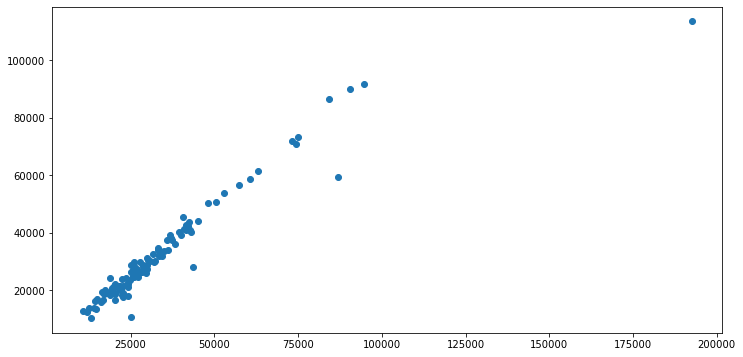

In [84]:
# Visualize how accurate predictions are 
plt.figure(figsize = (12, 6))
plt.scatter(y_test, predictions)

### 7. Delete the endpoint

In [85]:
linear_regressor.delete_endpoint()